In [1]:
from src.federated_pipeline import Federated_AVG, Federated_LICCHAVI

import os
import pickle
import collections

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

# Vocabulary Analysis

In [3]:
federated_wiki = Federated_AVG(
    "CONFIG_MODEL_WIKI.json",
    "CONFIG_FEDERATED_WIKI.json",
    testing = True
)

federated_tweets = Federated_AVG(
    "CONFIG_MODEL_TWEETS.json",
    "CONFIG_FEDERATED_TWEETS.json",
    testing = True
)

100%|██████████| 105/105 [00:12<00:00,  8.17it/s]


In [4]:
def compute_tf_idf(federated):
    for i, node in federated.nodes.items():
        node_vector = {k:0 for k in range(federated.vocabulary.get_vocab_size())}
        for b in node.data:
            x = collections.Counter(b.cpu().numpy())
            del x[0]
            del x[1]
            for k,v in x.items():
                node_vector[k] += v
        node_vector = np.array(list(node_vector.values()))
        node_vector = node_vector / np.max(node_vector) # node_vector = term frequency
        if i == 1:
            node_vectors = node_vector
        else:
            node_vectors = np.vstack((node_vectors, node_vector))

    count_doc = np.sum(np.where(node_vectors > 0, 1, 0), axis = 0) # number of times term appears in diff doc
    mask = (count_doc != 0)
    count_doc = count_doc[mask]
    node_vectors = node_vectors.T[mask].T
    idf = np.log(node_vectors.shape[0] / count_doc)
    tf_idf = node_vectors * idf
    norms = np.linalg.norm(tf_idf, axis = 1)
    return tf_idf / norms[:, np.newaxis]

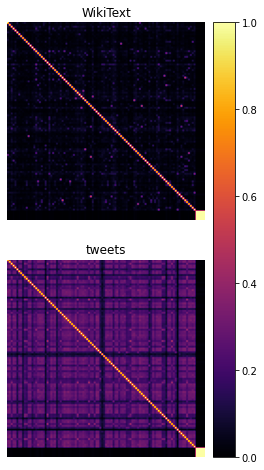

In [68]:
def compute_dist_matrix(federated, ax):
    tf_idf = compute_tf_idf(federated)
    
    return ax.imshow(
        tf_idf @ tf_idf.T,
        extent=(0,100,0,100), aspect='equal', cmap = 'inferno'
    )

fig, axes = plt.subplots(
    nrows=2, ncols=1,
    figsize = (6, 8),
    sharey = True, sharex = True
)


im1 = compute_dist_matrix(federated_wiki, axes[0])
axes[0].set_title('WikiText')
axes[0].set_axis_off()

im2 = compute_dist_matrix(federated_tweets, axes[1])
axes[1].set_title('tweets')
axes[1].set_axis_off()

cax = plt.axes([0.76, 0.126, 0.05, 0.755])
plt.colorbar(im2, cax=cax)

plt.savefig('plots/heterogeneity')
plt.show()

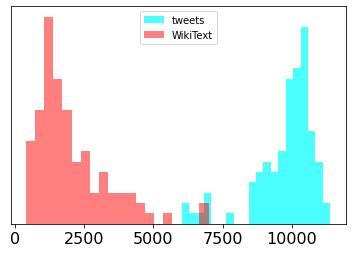

In [67]:
token_lengths = []
for i in range(1,101):
    token_lengths.append(federated_tweets.nodes[i].data.token_len())
plt.hist(token_lengths, bins = 20, alpha = 0.7, label = 'tweets', color = 'cyan')
token_lengths = []
for i in range(1,101):
    token_lengths.append(federated_wiki.nodes[i].data.token_len())
fig = plt.hist(token_lengths, bins = 20, alpha = 0.5, label='WikiText', color = 'red')
plt.yticks([])
plt.legend(loc = 'upper center')
plt.savefig('plots/token_distribution')
plt.tick_params(axis='x', which='major', labelsize=16)
plt.show()

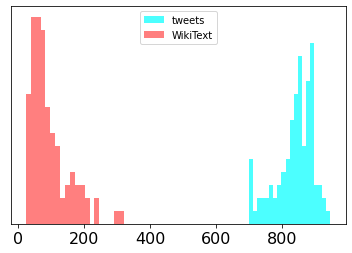

In [66]:
sequence_length = []
for i in range(1,101):
    sequence_length.append(len(federated_tweets.nodes[i].data))
plt.hist(sequence_length, bins = 20, alpha = 0.7, label = 'tweets', color = 'cyan')
sequence_length = []
for i in range(1,101):
    sequence_length.append(len(federated_wiki.nodes[i].data))
plt.hist(sequence_length, bins = 20, alpha = 0.5, label='WikiText', color = 'red')
plt.yticks([])
plt.savefig('plots/sequence_distribution')
plt.legend(loc = 'upper center')
plt.legend(loc = 'upper center')
plt.tick_params(axis='x', which='major', labelsize=16)
plt.show()